In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
#from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
import astropy.units as u
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
def busqueda(expression,column):
    m = re.search(expression,column)
    if m == None:
        return np.nan
    else :
        return m.group(0)

In [255]:
df_1 = pd.read_csv("skiff_2arcsec_internal_match.csv")

In [256]:
df_1["sptype"] = df_1["sptype"].astype(str)

In [257]:
df_1["Sptype_with_?"] = df_1.apply(lambda row: busqueda("\?",row["sptype"]),axis=1)  

In [258]:
df_1["Sptype_with_emision"] = df_1.apply(lambda row: busqueda(r"(\[e\]|\(e\)|e)",row["sptype"]),axis=1)  

In [259]:
df_1["Sptype_duda_en_numero"] = df_1.apply(lambda row: busqueda(r"[a-zA-Z]\d+/\d+",row["sptype"]),axis=1)  

In [260]:
df_1["Luminosity_class"] = df_1.apply(lambda row: busqueda(r"(I{1,3}|I[ab]|V)",row["sptype"]),axis=1)  

In [261]:
df_1["early_late"] = df_1.apply(lambda row: busqueda(r"^[a-zA-Z]\d+| [a-zA-Z]\d+\.\d+| [a-zA-Z]\d+/\d+",row["sptype"]),axis=1)  

In [262]:
df_1["binaries"] = df_1.apply(lambda row: busqueda("\+",row["sptype"]),axis=1)  

In [263]:
df_1["O_star"] = df_1.apply(lambda row: busqueda("O",row["sptype"]),axis=1)  

In [264]:
df_1["OB_star"] = df_1.apply(lambda row: busqueda(r"O[B/]",row["sptype"]),axis=1)  

In [265]:
df_1["sd_star"] = df_1.apply(lambda row: busqueda(r"sd",row["sptype"]),axis=1)  

In [266]:
df_1["mk"] = df_1.apply(lambda row: busqueda(r"^(O|B|A|F|G|K|M)",row["sptype"]),axis=1)  

In [267]:
df_1["year"] = df_1.apply(lambda row: busqueda(r"\d{4}",row["Bibcode"]),axis=1)  

In [268]:
df_1["arxiv"] = df_1.apply(lambda row: busqueda(r"arXiv",row["Bibcode"]),axis=1)  

In [269]:
df_1.loc[df_1["arxiv"].notna(),"year"] = "20" + df_1.loc[df_1["arxiv"].notna()]["year"].astype("str").str[:2]

In [270]:
df_1["year"] = pd.to_numeric(df_1["year"],errors="coerce")

In [271]:
df_1 = df_1.loc[(df_1["OB_star"].isna())&
      (df_1["sd_star"].isna())&
    (df_1["OB_star"].isna())&
         (df_1["binaries"].isna())&
      (df_1["mk"].notna())]

In [272]:
def spectral_type_to_numbers(sp):
    sp_types = ["O","B","A","F","G","K","M"]
    return sp_types.index(sp) 
    
    

In [273]:
df_1["numeric_sp"] = df_1.apply(lambda row: spectral_type_to_numbers(row["mk"]),axis=1)  

In [274]:
df_1["numeric_sp_labels"] = df_1["numeric_sp"] + df_1["early_late"].str[1:].astype(float)/10

In [277]:
df_1.loc[(df_1["numeric_sp_labels"].isna()),"numeric_sp_labels"] = df_1.loc[(df_1["numeric_sp_labels"].isna())]["numeric_sp"] + 0.55

In [384]:
# si realmente es el mismo objeto
#keywoard de los papers S/N y/o R
# Pasar a numeros los tipos espectrales redondear!
# Escribir en la tesis como determinar tipos espectrales
stars_unicas = df_1.loc[df_1["GroupID"].isna()]
star_no_unicas = df_1.loc[df_1["GroupID"].notna()]
#df_1 = pd.concat([stars_unicas,star_no_unicas])

In [385]:
# Calcula la desviación estándar dentro de cada grupo
std_by_group = star_no_unicas.groupby("GroupID")["numeric_sp_labels"].transform("std")

# Agrega la columna al DataFrame
star_no_unicas["std_sp"] = std_by_group

/tmp/ipykernel_6402/1249461170.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_no_unicas["std_sp"] = std_by_group


In [388]:
star_no_unicas = star_no_unicas.loc[(star_no_unicas["std_sp"]<0.5)|(star_no_unicas["std_sp"].isna())]

In [389]:
mean_by_group = star_no_unicas.groupby("GroupID")["numeric_sp_labels"].transform("mean")

# Agrega la columna al DataFrame
star_no_unicas["mean_sp"] = mean_by_group

/tmp/ipykernel_6402/352407341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_no_unicas["mean_sp"] = mean_by_group


In [395]:
star_no_unicas = star_no_unicas.sort_values(by="year",ascending=False).drop_duplicates(subset="GroupID")

In [397]:
df_1 = pd.concat([star_no_unicas,stars_unicas])

In [398]:
df_1.to_csv("skiff_2arcsec_internal_match_preprocesing.csv",index=False)

## Corregir coordenadas a J2016

In [3]:
import pandas as pd
df_1 = pd.read_csv("skiff_2arcsec_internal_match_preprocesing.csv")

/tmp/ipykernel_8059/1935470601.py:2: DtypeWarning: Columns (4,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv("skiff_2arcsec_internal_match_preprocesing.csv")


In [32]:
a = SkyCoord(df_1["RAJ2000"],df_1["DEJ2000"], unit=(u.hourangle, u.deg))

In [37]:
#df_1.to_csv("skiff_2arcsec_internal_match_preprocesing.csv",index=False)

### Condiciones del paper de Zari

In [113]:
df = df_1

In [85]:
#Establece magnitud g menor a 16, perdemos esta cantidad de estrellas
# mi muestra esta mas limpia que la de Zari pero menos completa
# Crear distribuciones de tipos espectrales del catalogo inicial 
df_1.loc[df_1["phot_g_mean_mag"]>16].groupby("label").count()[["name"]] / \
    df_1.groupby("label").count()[["name"]] *100

,name
label,
0.0,87.532917
1.0,94.491960
2.0,98.800539


Usan un proxy de magnitud absoluta en K

$\omega = 10^{\frac{10-K_{s}-0.0}{5}}$

In [86]:
df_1.loc[df_1["parallax"] > 10**((10-df_1["ks_m"] - 0.0)/5)].groupby("label").count()[["name"]] / \
    df_1.groupby("label").count()[["name"]]
#corregir celda

,name
label,
0.0,0.571819
1.0,0.043791
2.0,0.086119


In [87]:
df_1 = df_1.loc[(df_1["phot_g_mean_mag"]<16)&
               (df_1["parallax"] < 10**((10-df_1["ks_m"] - 0.0)/5))]

In [89]:
df_1.groupby("label").count()[["name"]]

,name
label,
0.0,232932
1.0,2655
2.0,6716


Aqui realizan un corte de colores en base a Poggio et al. (2018)

Utilizan un corte menor a 0.1 y mayor a -0.3 en $(J-K)_{0}$, donde lo definen de la forma 

$(J-K)_{0} = J-K_{s}-0.25(G-K_{s})$ 

In [29]:
df_1.loc[(df_1["j_m"]-df_1["ks_m"]-0.25*(df_1["phot_g_mean_mag"] - df_1["ks_m"]) >0.1)|(df_1["j_m"]-df_1["ks_m"]-0.25*(df_1["phot_g_mean_mag"] - df_1["ks_m"])<-0.3)].groupby("label").count()[["name"]] / \
    df_1.groupby("label").count()[["name"]]

,name
label,
0.0,0.480514
1.0,0.178154
2.0,0.077576


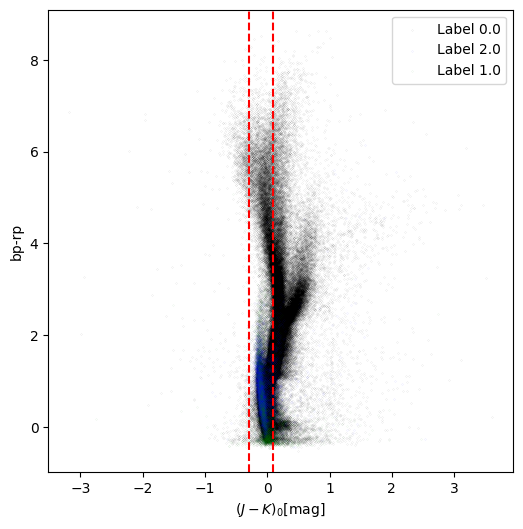

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Mapeo de valores únicos de la columna "label" a colores
colors = {0: 'black', 1: 'green', 2: 'blue'}

for label_value in df_1["label"].unique():
    label_df = df_1[df_1["label"] == label_value]
    ax.scatter(
        x=label_df["j_m"] - label_df["ks_m"]-0.25*(label_df["phot_g_mean_mag"] - label_df["ks_m"]),
        y=label_df["phot_bp_mean_mag"] - label_df["phot_rp_mean_mag"],
        s=0.001,
        color=colors[label_value],
        label=f"Label {label_value}"
    )

ax.set_xlabel("$(J-K)_{0}$[mag]")
ax.set_ylabel("bp-rp")
ax.legend()
plt.axvline(x=0.1,color="red", linestyle="--")
plt.axvline(x=-0.3,color="red", linestyle="--")


plt.show()


In [31]:
df_1 = df_1.loc[(df_1["j_m"]-df_1["ks_m"]-0.25*(df_1["phot_g_mean_mag"] - df_1["ks_m"]) <0.1)&
                (df_1["j_m"]-df_1["ks_m"]-0.25*(df_1["phot_g_mean_mag"] - df_1["ks_m"])>-0.3)]

ahora separarán estrellas O y B de estrellas rojas
J − H < 0.15(G − Ks) + 0.05
J − H > 0.15(G − Ks) − 0.15,

In [32]:
df_1.loc[((df_1["j_m"]-df_1["h_m"])>\
         0.15*(df_1["phot_g_mean_mag"]-df_1["ks_m"])+0.05)|
        ((df_1["j_m"]-df_1["h_m"])<\
         0.15*(df_1["phot_g_mean_mag"]-df_1["ks_m"])-0.15)].groupby("label").count()[["name"]] / \
    df_1.groupby("label").count()[["name"]]

,name
label,
0.0,0.539250
1.0,0.124656
2.0,0.025182


In [33]:
df_1 = df_1.loc[((df_1["j_m"]-df_1["h_m"])<\
         0.15*(df_1["phot_g_mean_mag"]-df_1["ks_m"])+0.05)&
        ((df_1["j_m"]-df_1["h_m"])>\
         0.15*(df_1["phot_g_mean_mag"]-df_1["ks_m"])-0.15)]

eliminar gigantes

G > 2(G − Ks) + 3,

In [36]:
df_1.loc[df_1["phot_g_mean_mag"]<\
        2*(df_1["phot_g_mean_mag"]-df_1["ks_m"])+3].groupby("label").count()[["name"]] / \
    df_1.groupby("label").count()[["name"]]

,name
label,
0.0,0.067225
1.0,0.016754
2.0,0.003809


In [38]:
df_1 = df_1.loc[df_1["phot_g_mean_mag"]>\
        2*(df_1["phot_g_mean_mag"]-df_1["ks_m"])+3]

No quedo claro si van a quitar estas estrellas variables, deberían ser RRlyraes y eclipsantes las 2 secuencias que se ven aprox en 1.6 y 1

In [39]:
df_1["AMP_bp_rp"] = (np.sqrt(df_1["phot_bp_n_obs"])/df_1["phot_bp_mean_flux_over_error"]) / \
    (np.sqrt(df_1["phot_rp_n_obs"])/df_1["phot_rp_mean_flux_over_error"])
df_1["AMP_G"] = np.sqrt(df_1["phot_g_n_obs"])/df_1["phot_g_mean_flux_over_error"]

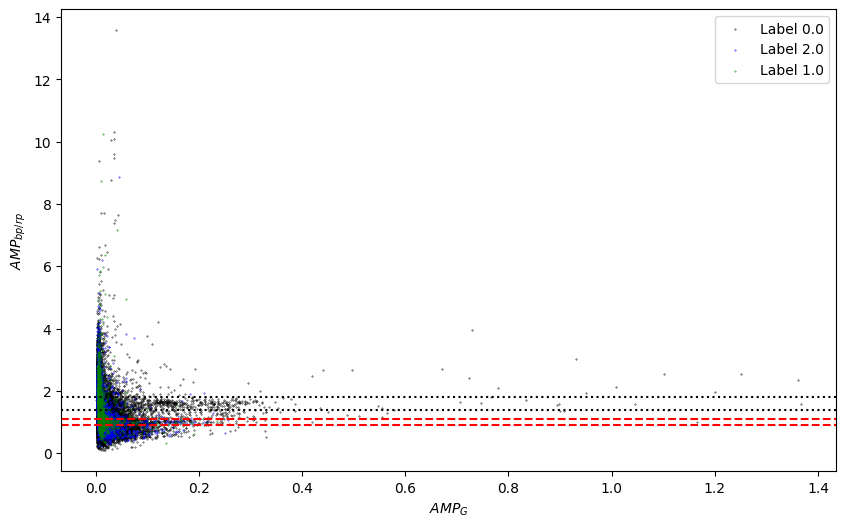

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Mapeo de valores únicos de la columna "label" a colores
colors = {0: 'black', 1: 'green', 2: 'blue'}

for label_value in df_1["label"].unique():
    label_df = df_1[df_1["label"] == label_value]
    ax.scatter(
        x=label_df["AMP_G"],
        y=label_df["AMP_bp_rp"],
        s=0.1,
        color=colors[label_value],
        label=f"Label {label_value}"
    )

ax.set_xlabel("$AMP_{G}$")
ax.set_ylabel("$AMP_{bp/rp}$")

plt.axhline(y=1.8,color="black", linestyle=":")
plt.axhline(y=1.4,color="black", linestyle=":")

plt.axhline(y=1.1,color="red", linestyle="--")
plt.axhline(y=0.9,color="red", linestyle="--")


ax.legend()
plt.show()

In [38]:
df_1.to_csv("skiff_gaia_2mass_clean.csv",index=False)

###  Balanced random forest sin corrección

In [114]:
df = pd.read_csv("skiff_gaia_2mass_clean.csv")

/tmp/ipykernel_6244/3295540216.py:1: DtypeWarning: Columns (50,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("skiff_gaia_2mass_clean.csv")


In [127]:
df.groupby("label").count()["name"]
#Resultado taza de contaminación de a cuerdo a estas etiquetas
#Revisar los 3000 papers y revisar indicador externo 
#Bp - Rp podria limpiar las F
# Lower limit, puede ser mas alta
# entrenar con 3 labels!

label
0.0    52005
1.0     1878
2.0     6016
Name: name, dtype: int64

In [118]:
#sns.histplot(data=df,x="mk")

In [119]:
mag_features = ['j_m', 'h_m', 'ks_m','phot_g_mean_mag',
                           'phot_bp_mean_mag', 'phot_rp_mean_mag']

In [123]:
from itertools import combinations
colors =[]
for v in combinations(mag_features, 2):
    df[f"{v[0]}-{v[1]}"] = df[v[0]] - df[v[1]]
    colors.append(f"{v[0]}-{v[1]}")
    

In [122]:
# no puedo perdecir etiqueta 2 
# agregaría los 3 labels!

In [124]:
df_rf = df.loc[df["label"]!=2][["pmdec","parallax","pmra","label"]+colors]

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     10435
         1.0       0.12      0.82      0.21       342

    accuracy                           0.81     10777
   macro avg       0.56      0.81      0.55     10777
weighted avg       0.97      0.81      0.87     10777



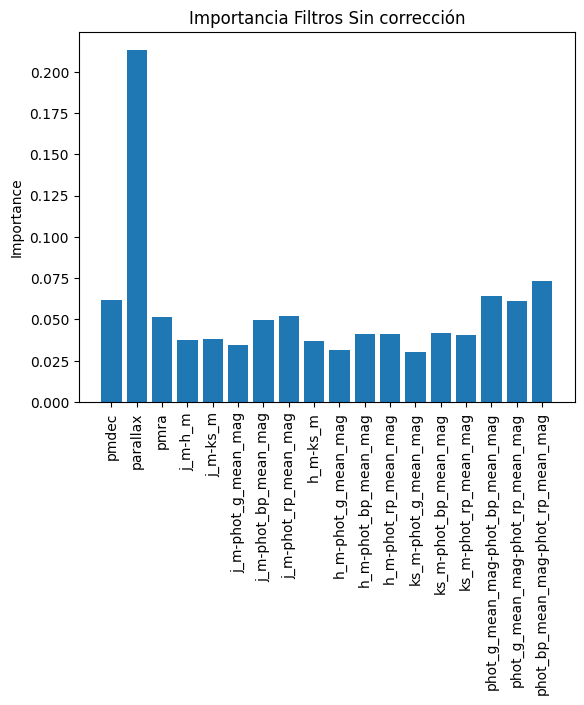

In [125]:
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns={"label"}),
                                                    df_rf["label"], test_size=0.2, random_state=42)

df.loc[X_train.index,"split"] = "train"
df.loc[X_test.index,"split"] = "test"

# Definir el modelo
model = BalancedRandomForestClassifier(n_estimators=500,random_state=42)
model.fit(X_train, y_train)
# Revisar criterios usar ambos
# Porcentaje o numero entero en el min sample split
# Mirar la documentación y optimizar hyperparametros, sampling stategy!

y_predict = model.predict(X_test)

resultados = pd.DataFrame({"y_predict":y_predict,"y_test":y_test})

print(classification_report(y_test, y_predict))


import matplotlib.pyplot as plt

# Datos de ejemplo
x = model.feature_names_in_
y = model.feature_importances_

# Crear el gráfico de barras
plt.bar(x, y)

# Opcional: Personalizar el gráfico
plt.ylabel('Importance')
plt.title('Importancia Filtros Sin corrección')
plt.xticks(rotation='vertical')

# Mostrar el gráfico
plt.show()



In [ ]:
IFAS para medidas de Halpha, debería servir bastante para dividir Oes y Bes
Estrellas O emiten en rayos X 
 Posible idea "https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/uhb/node136.html
    https://www.vphasplus.org/ 
    https://www.iphas.org/ tiene u

In [7]:
model.predict(df[["pmdec","parallax","pmra"]+colors]) 

array([0., 0., 0., ..., 0., 0., 0.])

In [128]:
df["rf_predict"] = model.predict(df[["pmdec","parallax","pmra"]+colors]) 

In [129]:
df_1 = df.loc[df["rf_predict"]!=0]

In [138]:
df["split"]

0        train
1        train
2        train
3        train
4         test
         ...  
59894    train
59895    train
59896    train
59897    train
59898    train
Name: split, Length: 59899, dtype: object

In [143]:
df_review = df.loc[(df["rf_predict"]==1)&(df["split"]=="test")]

In [145]:
df_review.loc[df_review["label"]==0].groupby("mk").count()["name"]

mk
A     198
B    1416
F      79
G      17
K       2
M      11
Name: name, dtype: int64

In [146]:
198/1416

0.13983050847457626

In [149]:
14497/30824

0.4703153386971191

In [150]:
df_1

,name,sptype,bibcode,source_id,ra,dec,ra_error,dec_error,parallax,parallax_error,...,h_m-phot_bp_mean_mag,h_m-phot_rp_mean_mag,ks_m-phot_g_mean_mag,ks_m-phot_bp_mean_mag,ks_m-phot_rp_mean_mag,phot_g_mean_mag-phot_bp_mean_mag,phot_g_mean_mag-phot_rp_mean_mag,phot_bp_mean_mag-phot_rp_mean_mag,split,rf_predict
22,JL 76,B2V,1977MNRAS.180p..31B,6348013516630089600,322.772001,-82.681432,0.012610,0.013970,0.122137,0.015700,...,-0.267812,-0.079797,-0.120970,-0.173813,0.014203,-0.052843,0.135173,0.188016,train,1.0
50,NSV 5313,A3/6,1998A&AS..131..115C,5199521463337441152,176.050334,-80.193009,0.018525,0.019063,0.226265,0.018960,...,-1.930328,-1.031173,-1.628895,-1.990328,-1.091173,-0.361433,0.537722,0.899155,test,1.0
57,SOPS Ia-216,OB-,1972POAN....2...59S,5784536347386426624,201.243944,-79.750117,0.016352,0.015946,0.106836,0.019451,...,0.350538,0.206725,0.330375,0.383538,0.239725,0.053163,-0.090650,-0.143813,NaN,1.0
60,SOPS Ia-213,OB-,1972POAN....2...59S,5200546586130959744,166.289165,-79.362332,0.019892,0.017272,0.169451,0.021138,...,-0.069871,-0.006728,-0.031265,-0.043871,0.019272,-0.012606,0.050537,0.063143,NaN,1.0
70,SOPS Ia-209,OB,1972POAN....2...59S,5788398313259527808,186.408724,-78.797513,0.023525,0.019014,0.187114,0.024753,...,-0.479261,-0.352803,-0.626556,-0.576261,-0.449803,0.050295,0.176753,0.126458,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59869,NGC 6705 Str 663,A5:,1925LicOB..12...10T,4252502748189542400,282.813209,-6.265053,0.016050,0.020357,0.451592,0.027922,...,-1.862153,-0.948872,-1.645575,-1.989153,-1.075872,-0.343578,0.569703,0.913281,train,1.0
59883,HD 225563,A,1925AnHar.100....1C,2047732345358266240,296.035520,35.111018,0.061610,0.066032,0.407392,0.081663,...,-0.322541,-0.172670,-0.678761,-0.339541,-0.189670,0.339220,0.489091,0.149871,train,1.0
59891,HD 147792,A0,1921AnHar..96.....C,5993094663582797696,246.415740,-40.655231,0.181629,0.139302,0.490554,0.214927,...,-1.880835,-0.884265,-1.647615,-2.032835,-1.036265,-0.385220,0.611350,0.996570,test,1.0
59896,CD-40 5337,A2,1919AnHar..94.....C,5425558101706488192,143.861476,-41.451704,0.199545,0.209763,0.243878,0.291947,...,-0.374896,-0.180279,-0.832027,-0.445896,-0.251278,0.386131,0.580749,0.194618,train,1.0


In [ ]:
# se equivoca mas con las B entonces esta clasificando cosas mas azules
# Como calculo el tipo espectral representativo y estar seguro que es el mismo objeto
# Cuantos objetos cumplen los objetos de Zari y no tienen tipos expectrales --> Descargar desde simbad
# Buscar espectros para los que no esten en zari
# Otros datos
# Labels gorupby 5 tipos espectrales vemos una dispersión mayor de danto no uso el objeto
# Label hago un sigma clipping con los numeros
distribucion de las dispersiones de tipo espectrales, hacemos corte cuando se va de la normal
Para los otros que no tienen dispersones extremas me quedo con un tipo expectral mediano
Me quedo con unas coordenadas medianas y esas uso para hacer el cross match

In [148]:
df.groupby("mk").count()["name"]

mk
A    14497
B    30824
F     2976
G      380
K       68
M       61
O     7849
Name: name, dtype: int64

In [58]:
pd.set_option('display.max_row', 10)


In [ ]:
import joblib
joblib.dump(model, 'r_f_sin_correccion.joblib')

In [59]:
df_1.to_csv("candidate_to_massive_stars.csv",index=False)

In [62]:
df_1["source_id"].to_csv("source_id_Candidatas_massive_stars.csv",index=False)

## Resta colores consecutivos

In [81]:
sample = pd.read_csv("skiff_UCAC4_topcat_labels.csv")
sample = sample.loc[sample["label"]!=2].reset_index(drop=True)

mag_features = sample[['Jmag', 'Hmag', 'Kmag', 'Bmag', 'Vmag',
       'Gmag', 'Rmag', 'Imag']]


df_rf = sample[["Name","label"]].reset_index(drop=True)

combinaciones = [
    "Bmag-Vmag",
    "Vmag-Gmag",
    "Gmag-Rmag",
    "Rmag-Imag",
    "Jmag-Hmag",
    "Jmag-Kmag"]
for v in combinaciones :
    magnitudes = v.split("-")
    df_rf[v] = sample[magnitudes[0]] - sample[magnitudes[1]]

/tmp/ipykernel_22667/4136818439.py:1: DtypeWarning: Columns (5,42,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sample = pd.read_csv("skiff_UCAC4_topcat_labels.csv")


              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     75160
         1.0       0.02      0.87      0.05       283

    accuracy                           0.87     75443
   macro avg       0.51      0.87      0.49     75443
weighted avg       1.00      0.87      0.93     75443



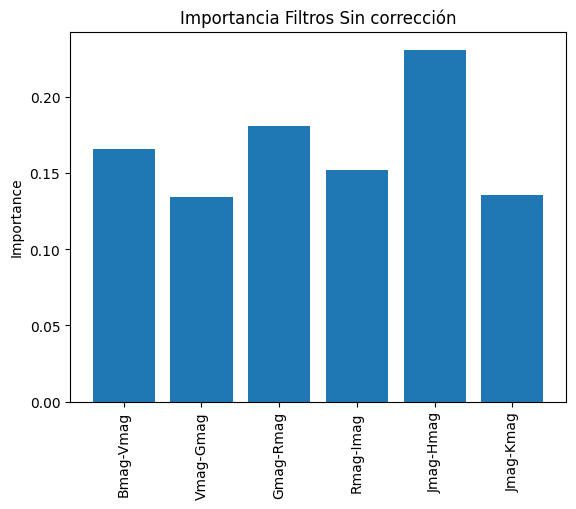

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns={"Name","label"}),
                                                    df_rf["label"], test_size=0.2, random_state=42)



# Definir el modelo
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

resultados = pd.DataFrame({"y_predict":y_predict,"y_test":y_test})

print(classification_report(y_test, y_predict))


import matplotlib.pyplot as plt

# Datos de ejemplo
x = model.feature_names_in_
y = model.feature_importances_

# Crear el gráfico de barras
plt.bar(x, y)

# Opcional: Personalizar el gráfico
plt.ylabel('Importance')
plt.title('Importancia Filtros Sin corrección')
plt.xticks(rotation='vertical')

# Mostrar el gráfico
plt.show()


###  Balanced random forest corregido

In [78]:
sample = pd.read_csv("skiff_UCAC4_topcat_labels.csv")
sample = sample.loc[sample["label"]!=2].reset_index(drop=True)

data = {
    "Bmag": 3.626,
    "Vmag": 2.742,
    "Gmag": 3.303,
    "Rmag": 2.285,
    "Imag": 1.698,
    "Jmag": 0.709,
    "Hmag": 0.449,
    "Kmag": 0.302
}

coords = SkyCoord(sample["_RAJ2000"],sample["_DEJ2000"], unit='deg').galactic
sfd = SFDQuery()
sample["ebv"] = sfd(coords)

for key, value in data.items():
    sample[key] = sample[key] - (value * sample["ebv"])
    
mag_features = sample[['Jmag', 'Hmag', 'Kmag', 'Bmag', 'Vmag',
       'Gmag', 'Rmag', 'Imag']]

df_rf = sample[["Name","label"]].reset_index(drop=True)

from itertools import combinations
for v in combinations(mag_features, 2):
    df_rf[f"{v[0]}-{v[1]}"] = sample[v[0]] - sample[v[1]]

/tmp/ipykernel_22667/584730718.py:1: DtypeWarning: Columns (5,42,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sample = pd.read_csv("skiff_UCAC4_topcat_labels.csv")


The SFD'98 dust map is not in the data directory:

    /home/nico/universidad/dustmap

To change the data directory, call:

    from dustmaps.config import config
    config['data_dir'] = '/path/to/data/directory'

To download the SFD'98 map to the data directory, call:

    import dustmaps.sfd
    dustmaps.sfd.fetch()



FileNotFoundError: [Errno 2] No such file or directory: '/home/nico/universidad/dustmap/sfd/SFD_dust_4096_ngp.fits'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns={"Name","label"}),
                                                    df_rf["label"], test_size=0.2, random_state=42)



# Definir el modelo
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

resultados = pd.DataFrame({"y_predict":y_predict,"y_test":y_test})

print(classification_report(y_test, y_predict))


import matplotlib.pyplot as plt

# Datos de ejemplo
x = model.feature_names_in_
y = model.feature_importances_

# Crear el gráfico de barras
plt.bar(x, y)

# Opcional: Personalizar el gráfico
plt.ylabel('Importance')
plt.title('Importancia Filtros Sin corrección')
plt.xticks(rotation='vertical')

# Mostrar el gráfico
plt.show()


## Resta consecutiva corregida

/tmp/ipykernel_6276/1201379821.py:1: DtypeWarning: Columns (5,42,47,48,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("skiff_UCAC4_topcat_labels.csv")


              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91     68640
         1.0       0.02      0.92      0.04       287

    accuracy                           0.83     68927
   macro avg       0.51      0.87      0.47     68927
weighted avg       1.00      0.83      0.90     68927



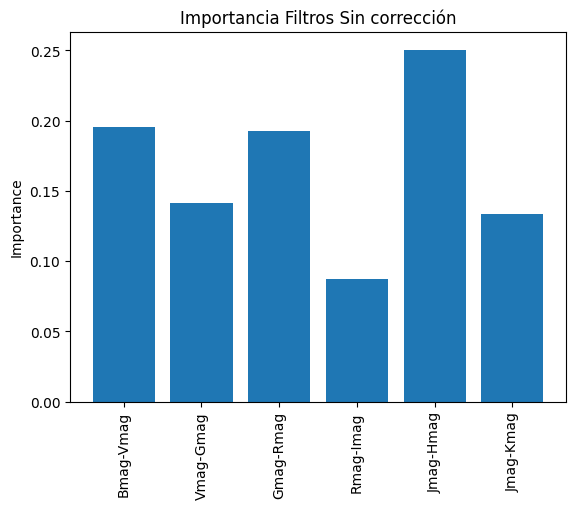

In [91]:
df = pd.read_csv("skiff_UCAC4_topcat_labels.csv")
sample = df.loc[df["prepro"]==1].reset_index(drop=True)

data = {
    "Bmag": 3.626,
    "Vmag": 2.742,
    "Gmag": 3.303,
    "Rmag": 2.285,
    "Imag": 1.698,
    "Jmag": 0.709,
    "Hmag": 0.449,
    "Kmag": 0.302
}

coords = SkyCoord(sample["_RAJ2000"],sample["_DEJ2000"], unit='deg').galactic
sfd = SFDQuery()
sample["ebv"] = sfd(coords)

for key, value in data.items():
    sample[key] = sample[key] - (value * sample["ebv"])
    
mag_features = sample[['Jmag', 'Hmag', 'Kmag', 'Bmag', 'Vmag',
       'Gmag', 'Rmag', 'Imag']]


df_rf = sample[["Name","label"]].reset_index(drop=True)

for v in combinaciones :
    magnitudes = v.split("-")
    df_rf[v] = sample[magnitudes[0]] - sample[magnitudes[1]]
    
    

X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns={"Name","label"}),
                                                    df_rf["label"], test_size=0.2, random_state=42)



# Definir el modelo
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

resultados = pd.DataFrame({"y_predict":y_predict,"y_test":y_test})

print(classification_report(y_test, y_predict))


import matplotlib.pyplot as plt

# Datos de ejemplo
x = model.feature_names_in_
y = model.feature_importances_

# Crear el gráfico de barras
plt.bar(x, y)

# Opcional: Personalizar el gráfico
plt.ylabel('Importance')
plt.title('Importancia Filtros Sin corrección')
plt.xticks(rotation='vertical')

# Mostrar el gráfico
plt.show()


### Pareciera que lo que anda mejor son los colores sin corrección

In [131]:
sample = pd.read_csv("skiff_UCAC4_topcat_labels_split.csv")
mag_features = sample[['Jmag', 'Hmag', 'Kmag', 'Bmag', 'Vmag',
       'Gmag', 'Rmag', 'Imag']]
df_rf = sample[["Name","label"]].reset_index(drop=True)

/tmp/ipykernel_22667/3528597407.py:1: DtypeWarning: Columns (5,42,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sample = pd.read_csv("skiff_UCAC4_topcat_labels_split.csv")


In [132]:
from itertools import combinations
for v in combinations(mag_features, 2):
    df_rf[f"{v[0]}-{v[1]}"] = sample[v[0]] - sample[v[1]]

In [133]:
loaded_model = joblib.load('r_f_sin_correccion.joblib')


In [141]:
sample["predict"] = loaded_model.predict(df_rf.drop(columns=["Name","label"]))
sample[["p1","p2"]] = loaded_model.predict_proba(df_rf.drop(columns=["Name","label"]))

In [169]:
sample = sample.loc[(sample["predict"]==1)|(sample["label"]==1)|(sample["label"]==2)].reset_index(drop=True)

In [170]:
sample.to_csv("catalog_filtros_colores.csv",index=False)